In [35]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from data_processing import getDatasets
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [25]:
# Load datasets
datasets = getDatasets()

# Speed bump columns
speed_bump_cols = ['no_speed_bump', 'speed_bump_asphalt', 'speed_bump_cobblestone']

# Combine left, right data and labels for each PVS
combined_datasets = pd.DataFrame({
    'pvs': list(datasets.keys()),
    'dataframe': [
        pd.concat([
            datasets[pvs_key]['data_left'].add_suffix('_left'),
            datasets[pvs_key]['data_right'].add_suffix('_right'),
            datasets[pvs_key]['data_labels'][speed_bump_cols].idxmax(axis=1).rename('speed_bump_class')
        ], axis=1)
        for pvs_key in datasets.keys()
    ]
})

In [26]:
# Encode speed_bump_class labels for all PVS dataframes
speed_bump_mapping = {
    'no_speed_bump': 0,
    'speed_bump_asphalt': 1,
    'speed_bump_cobblestone': 1
}

for df in combined_datasets['dataframe']:
    df['speed_bump_class'] = df['speed_bump_class'].map(speed_bump_mapping).astype('int8')

In [27]:
# Normalize sensor data and filter to relevant features
for i, row in combined_datasets.iterrows():
    df = row['dataframe'].copy()
    
    # Keep only acc, gyro, mag, and speed sensors
    allowed_keywords = ('acc', 'gyro', 'mag', 'speed')
    sensor_cols = [col for col in df.columns if col != 'speed_bump_class' and any(k in col for k in allowed_keywords)]
    
    # Normalize and update
    df_sensors = df[sensor_cols]
    df_sensors = pd.DataFrame(StandardScaler().fit_transform(df_sensors), columns=sensor_cols, index=df.index)
    df_sensors['speed_bump_class'] = df['speed_bump_class']
    combined_datasets.at[i, 'dataframe'] = df_sensors.fillna(0)

print(f"Sensor features: {len(sensor_cols)}, Sample shape: {combined_datasets.dataframe[0].shape}")

Sensor features: 50, Sample shape: (144036, 51)


In [28]:
# Check class imbalance
all_labels = pd.concat([df['speed_bump_class'] for df in combined_datasets['dataframe']])
counts = all_labels.value_counts().sort_index()

print("Class Distribution:")
print(f"  No speed bump: {counts[0]:7d} ({counts[0]/len(all_labels)*100:5.2f}%)")
print(f"  Speed bump:    {counts[1]:7d} ({counts[1]/len(all_labels)*100:5.2f}%)")
print(f"  Imbalance ratio: 1:{counts[0]/counts[1]:.1f}")

Class Distribution:
  No speed bump: 1063799 (98.42%)
  Speed bump:      17106 ( 1.58%)
  Imbalance ratio: 1:62.2


In [29]:
# Train/test split
train_idx, test_idx = [0, 1, 2, 6, 7, 8], [3, 4, 5]
selected_dfs_train = [combined_datasets['dataframe'][i] for i in train_idx]
selected_dfs_test = [combined_datasets['dataframe'][i] for i in test_idx]

print(f"Training: {[combined_datasets.iloc[i]['pvs'] for i in train_idx]}")
print(f"Testing:  {[combined_datasets.iloc[i]['pvs'] for i in test_idx]}")

Training: ['pvs_1', 'pvs_2', 'pvs_3', 'pvs_7', 'pvs_8', 'pvs_9']
Testing:  ['pvs_4', 'pvs_5', 'pvs_6']


In [30]:
# Create sliding windows with oversampling for speed bumps
def create_windows(df, window_size=100, stride=50, oversample=True):
    """Create sliding windows. Oversamples speed bump regions if oversample=True."""
    sensor_cols = [col for col in df.columns if col != 'speed_bump_class']
    
    # Convert to numpy arrays for faster operations
    sensor_data = df[sensor_cols].values  # (n_samples, n_features)
    labels = df['speed_bump_class'].values  # (n_samples,)
    
    X_windows, y_windows = [], []
    
    # Standard sliding window
    for start in range(0, len(df) - window_size + 1, stride):
        window = sensor_data[start:start + window_size].T  # (n_features, window_size)
        # Majority vote: use mean > 0.5 for binary labels (faster than mode)
        label = int(labels[start:start + window_size].mean() > 0.5)
        X_windows.append(window)
        y_windows.append(label)
    
    # Oversample speed bump regions with smaller stride
    if oversample:
        bump_indices = np.where(labels == 1)[0]
        if len(bump_indices) > 0:
            # Find contiguous regions
            regions = []
            current = [bump_indices[0]]
            for i in range(1, len(bump_indices)):
                if bump_indices[i] - bump_indices[i-1] <= 50:
                    current.append(bump_indices[i])
                else:
                    regions.append(current)
                    current = [bump_indices[i]]
            regions.append(current)
            
            # Dense sampling around bumps (stride=10 for more samples)
            for region in regions:
                start_region = max(0, min(region) - 50)
                end_region = min(len(df), max(region) + 50)
                for start in range(start_region, end_region - window_size + 1, 10):
                    window = sensor_data[start:start + window_size].T
                    label = int(labels[start:start + window_size].mean() > 0.5)
                    if label == 1:
                        X_windows.append(window)
                        y_windows.append(label)
    
    return np.array(X_windows), np.array(y_windows)

# Create windows for train and test
print("Creating windows (window_size=100, 1 second @ 100Hz)...")
X_train_list = [create_windows(df, oversample=True) for df in selected_dfs_train]
X_test_list = [create_windows(df, oversample=False) for df in selected_dfs_test]

X_train = np.vstack([x[0] for x in X_train_list])
y_train = np.hstack([x[1] for x in X_train_list])
X_test = np.vstack([x[0] for x in X_test_list])
y_test = np.hstack([x[1] for x in X_test_list])

print(f"Train: {X_train.shape}, Bumps: {np.sum(y_train==1)}/{len(y_train)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"Test:  {X_test.shape}, Bumps: {np.sum(y_test==1)}/{len(y_test)} ({np.sum(y_test==1)/len(y_test)*100:.1f}%)")

Creating windows (window_size=100, 1 second @ 100Hz)...
Train: (15474, 50, 100), Bumps: 1346/15474 (8.7%)
Test:  (7248, 50, 100), Bumps: 110/7248 (1.5%)


In [31]:
# Create PyTorch DataLoaders
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"DataLoaders: {len(train_loader)} train batches, {len(test_loader)} test batches")

DataLoaders: 61 train batches, 29 test batches


### Create CNN for Speed Bump Detection

In [32]:
# CNN for speed bump detection (binary classification)
class SpeedBumpCNN(nn.Module):
    def __init__(self, input_channels, num_classes=2):
        super().__init__()
        # Multi-scale temporal feature extraction - adapted for 1 second windows
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=100, padding=50),  # 1.0s patterns (full window)
            nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2), nn.Dropout(0.15))
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=50, padding=25),  # 0.5s patterns
            nn.ReLU(), nn.BatchNorm1d(128), nn.MaxPool1d(2), nn.Dropout(0.2))
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=25, padding=12),  # 0.25s patterns
            nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.25))
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, num_classes))
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x).squeeze(2)
        return self.classifier(x)

model = SpeedBumpCNN(input_channels=X_train.shape[1], num_classes=2)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input shape: (batch, {X_train.shape[1]} features, {X_train.shape[2]} timesteps)")

Parameters: 1,583,298
Input shape: (batch, 50 features, 100 timesteps)


Class weights: [0.17396924 1.8260307 ]
Epoch  1: Loss 0.1975/0.2714, Acc 89.65/90.51%
Epoch  2: Loss 0.0945/0.1887, Acc 95.88/92.12%
Epoch  3: Loss 0.0549/0.1666, Acc 97.80/94.61%
Epoch  4: Loss 0.0477/0.2422, Acc 98.11/93.56%
Epoch  5: Loss 0.0323/0.1591, Acc 98.64/97.76%
Epoch  6: Loss 0.0321/0.1051, Acc 98.79/96.96%
Epoch  7: Loss 0.0341/0.1241, Acc 98.45/98.47%
Epoch  8: Loss 0.0214/0.1557, Acc 99.15/98.81%
Epoch  9: Loss 0.0257/0.2066, Acc 99.11/97.21%
Epoch 10: Loss 0.0218/0.1746, Acc 99.11/98.37%
Epoch 11: Loss 0.0231/0.1388, Acc 99.11/98.17%
Epoch 12: Loss 0.0263/0.1515, Acc 98.84/97.57%
Epoch 13: Loss 0.0203/0.2762, Acc 99.18/98.85%
Epoch 14: Loss 0.0094/0.2541, Acc 99.70/98.84%
Epoch 15: Loss 0.0164/0.1735, Acc 99.44/98.47%
Epoch 16: Loss 0.0146/0.2561, Acc 99.42/98.98%
Epoch 17: Loss 0.0183/0.2073, Acc 99.33/98.12%
Epoch 18: Loss 0.0240/0.2170, Acc 99.04/98.70%
Epoch 19: Loss 0.0179/0.1968, Acc 99.26/98.69%
Epoch 20: Loss 0.0078/0.2705, Acc 99.66/98.98%
Epoch 21: Loss 0.0074

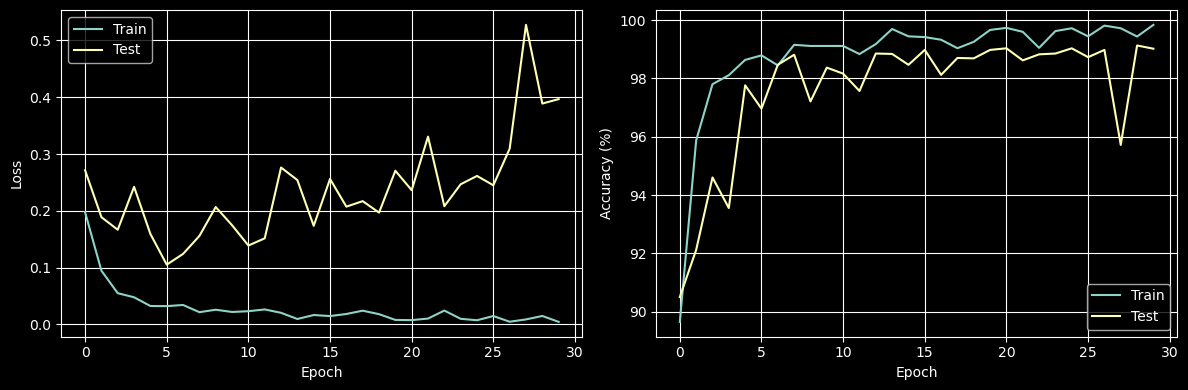

In [33]:
# Training
device = torch.device('mps')
model.to(device)

# Use class weights to handle imbalance
class_weights = torch.FloatTensor([1.0/c for c in np.bincount(y_train)])
class_weights = (class_weights / class_weights.sum() * len(class_weights)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Class weights: {class_weights.cpu().numpy()}")

# Train and evaluate
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
epochs = 30

for epoch in range(1, epochs + 1):
    # Train
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(100 * correct / total)
    
    # Test
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    
    history['test_loss'].append(test_loss / len(test_loader))
    history['test_acc'].append(100 * correct / total)
    
    print(f"Epoch {epoch:2d}: Loss {history['train_loss'][-1]:.4f}/{history['test_loss'][-1]:.4f}, "
          f"Acc {history['train_acc'][-1]:.2f}/{history['test_acc'][-1]:.2f}%")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['test_loss'], label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['test_acc'], label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()


Confusion Matrix:
                  Predicted
           No Speed Bump      Speed Bump    
    No Speed Bump       7108               30        
       Speed Bump        41                69        

Key Metrics:
  Accuracy:    0.990
  Precision:   0.697 (% of bump predictions that are correct)
  Recall:      0.627 (% of actual bumps detected)
  Specificity: 0.996 (% of non-bumps correctly identified)


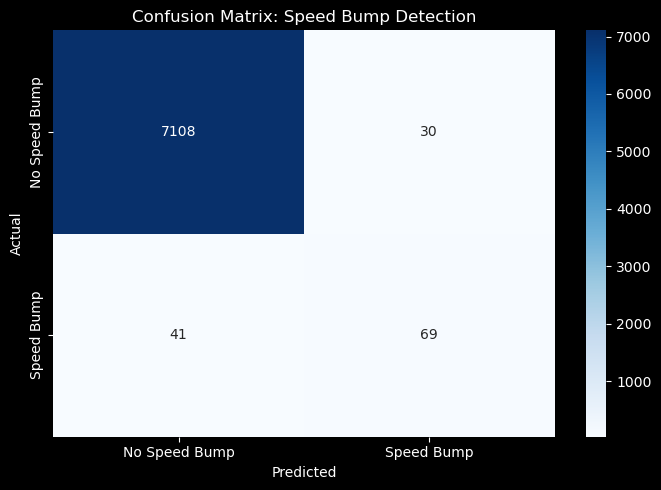


Classification Report:
               precision    recall  f1-score   support

No Speed Bump       0.99      1.00      1.00      7138
   Speed Bump       0.70      0.63      0.66       110

     accuracy                           0.99      7248
    macro avg       0.85      0.81      0.83      7248
 weighted avg       0.99      0.99      0.99      7248



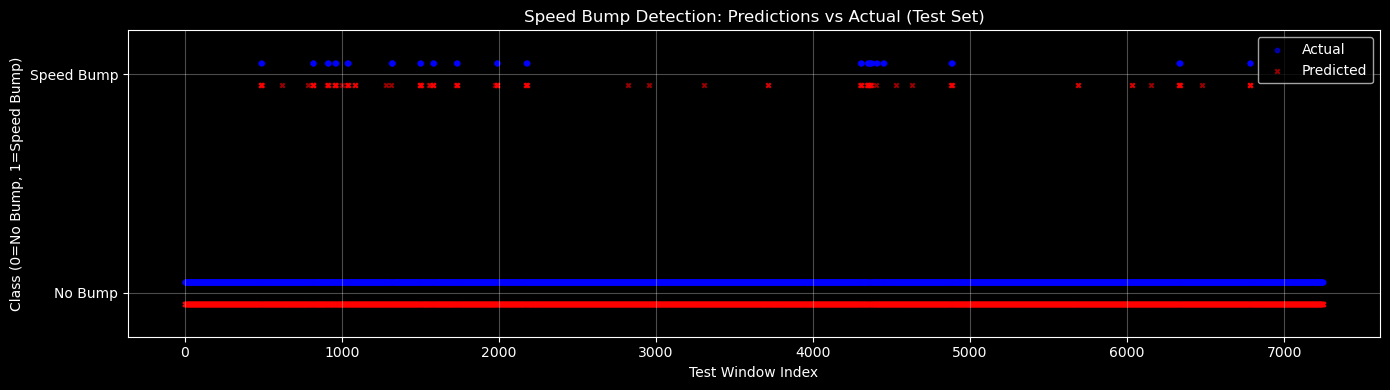

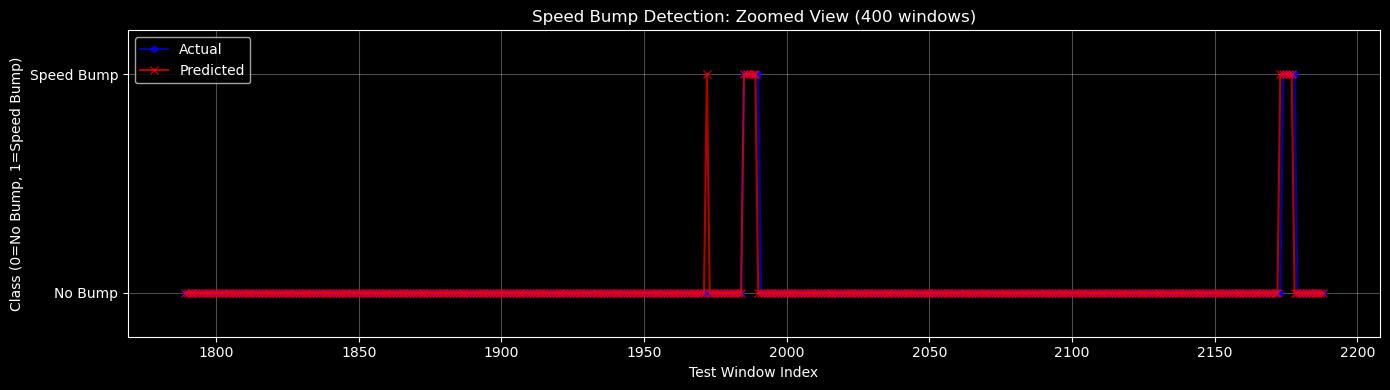

In [34]:
# Evaluation and Confusion Matrix
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        y_pred.extend(model(inputs).argmax(1).cpu().numpy())
        y_true.extend(labels.numpy())

y_pred, y_true = np.array(y_pred), np.array(y_true)
cm = confusion_matrix(y_true, y_pred)
class_names = ['No Speed Bump', 'Speed Bump']

# Confusion matrix
print("\nConfusion Matrix:")
print(f"                  Predicted")
print(f"         {class_names[0]:^17} {class_names[1]:^17}")
for i, true_class in enumerate(class_names):
    print(f"{true_class:>17} {cm[i][0]:^17d} {cm[i][1]:^17d}")

# Key metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nKey Metrics:")
print(f"  Accuracy:    {(tp+tn)/(tp+tn+fp+fn):.3f}")
print(f"  Precision:   {tp/(tp+fp):.3f} (% of bump predictions that are correct)")
print(f"  Recall:      {tp/(tp+fn):.3f} (% of actual bumps detected)")
print(f"  Specificity: {tn/(tn+fp):.3f} (% of non-bumps correctly identified)")

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Speed Bump Detection')
plt.tight_layout()
plt.show()

# Full report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Time series visualization of predictions vs actual
fig, ax = plt.subplots(figsize=(14, 4))
x_axis = np.arange(len(y_true))

# Plot actual labels (offset slightly for visibility)
ax.scatter(x_axis, y_true + 0.05, alpha=0.6, s=10, label='Actual', color='blue', marker='o')
# Plot predictions (offset slightly for visibility)
ax.scatter(x_axis, y_pred - 0.05, alpha=0.6, s=10, label='Predicted', color='red', marker='x')

ax.set_xlabel('Test Window Index')
ax.set_ylabel('Class (0=No Bump, 1=Speed Bump)')
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No Bump', 'Speed Bump'])
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Speed Bump Detection: Predictions vs Actual (Test Set)')
plt.tight_layout()
plt.show()

# Show a zoomed-in view of a region with speed bumps
bump_indices = np.where(y_true == 1)[0]
if len(bump_indices) > 0:
    # Find a region with bumps
    start_idx = max(0, bump_indices[len(bump_indices)//2] - 200)
    end_idx = min(len(y_true), start_idx + 400)
    
    fig, ax = plt.subplots(figsize=(14, 4))
    x_axis_zoom = np.arange(start_idx, end_idx)
    
    ax.plot(x_axis_zoom, y_true[start_idx:end_idx], 'o-', alpha=0.7, label='Actual', color='blue', markersize=4)
    ax.plot(x_axis_zoom, y_pred[start_idx:end_idx], 'x-', alpha=0.7, label='Predicted', color='red', markersize=6)
    
    ax.set_xlabel('Test Window Index')
    ax.set_ylabel('Class (0=No Bump, 1=Speed Bump)')
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['No Bump', 'Speed Bump'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title('Speed Bump Detection: Zoomed View (400 windows)')
    plt.tight_layout()
    plt.show()

In [ ]:
#joblib.dump(model, '../models/CNN_speed_bump_classification.pkl')

['../models/CNN_speed_bump_classification.pkl']